In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()                

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1: Do smokers have higher insurance charges than non-smokers?

H0 - There is no significant difference between the charges of non-smokers and smokers

H1 - There is a significant difference between the charges of non-smokers and smokers

Slignificance Level (Alpha) - 0.05

Test Type - 2 Sample T-Test

Assumptions:
* No significant outliers
* Normality
* Equal Variance

This code references the Coding Dojo lecture - [Walkthrough T-test](https://login.codingdojo.com/m/720/16269/120438)

In [3]:
# check how many customers in each group
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
# split data into two groups
non_smoker = df.loc[df['smoker']=='no'].copy()
smoker = df.loc[df['smoker']=='yes'].copy()

In [5]:
# isolate chargers in each data set
non_smoker_charges = non_smoker['charges']
smoker_charges = smoker['charges']

In [6]:
smoker_charges.head()

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

In [7]:
non_smoker_charges.count()

1064

In [8]:
# check for outliers - non-smoker
zscores = stats.zscore(non_smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [9]:
# remove outliers - non-smoker
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]

In [10]:
non_smoker_charges.count()

1040

In [11]:
# check for outliers - smoker
zscores = stats.zscore(smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [12]:
# check normality - non-smoker
results_non_smoker_charges = stats.normaltest(non_smoker_charges)
results_non_smoker_charges

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [13]:
# check normality - smoker
results_smoker_charges = stats.normaltest(smoker_charges)
results_smoker_charges

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

The p-values for both groups are below 0.05 which means the data is not normal, however,the sample size of each group is large enough (>15) to proceed without satisfying this test.

In [14]:
# check equal variance
result = stats.levene(non_smoker_charges, smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

The two samples do not have equal variance therefore I will include equal_var=False when performning the t-test

In [15]:
result = stats.ttest_ind(non_smoker_charges, smoker_charges, equal_var=False)
result

Ttest_indResult(statistic=-33.732305987092516, pvalue=2.575322662587431e-104)

The p-value is smaller than alpha (0.05) so we can reject the null hypothesis and accept that there is a significan difference between the charges of non-smokers and smokers

In [16]:
mean_ns = np.mean(non_smoker_charges)
mean_s = np.mean(smoker_charges)

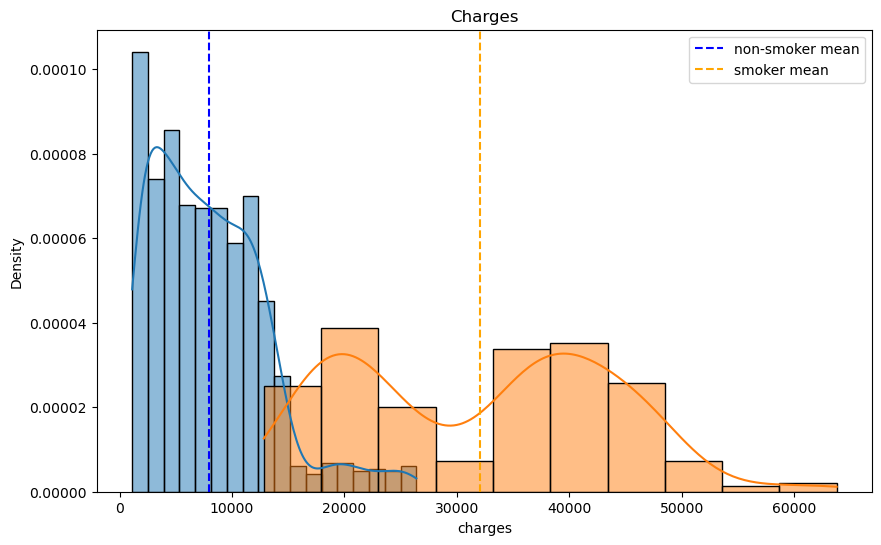

In [17]:
# visualize distribution of each group
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x=non_smoker_charges, stat='density',kde=True)
ax.axvline(mean_ns, color='blue',ls='--', label='non-smoker mean')

sns.histplot(x=smoker_charges, stat='density',kde=True)
ax.axvline(mean_s, color='orange', ls='--', label='smoker mean')

ax.set_title('Charges')
ax.legend();

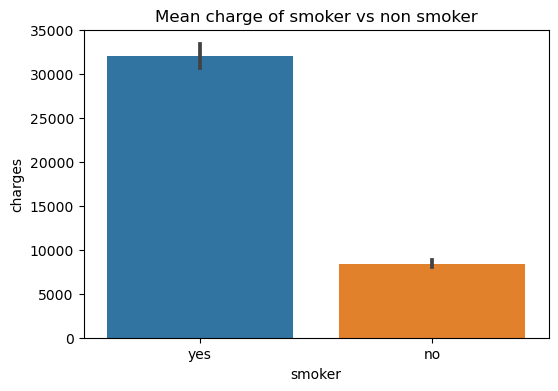

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=df['smoker'],y=df['charges'])
ax.set_title('Mean charge of smoker vs non smoker');

From the two visualisations above it can be seen that the average charge of smokers is much larger than that of non-smokers

## Q2:Are men more likely to smoke than women?

H0 - There is no relationship between sex and a clients smoking status

H1 - A clients sex influences their smoking status

Slignificance Level (Alpha) - 0.05

Test Type - Chi-squared

Assumptions:
* There are two categorical variables 
* The outcomes are independent

This code references the Coding Dojo lecture - [Categorical Hypothesis Testing](https://login.codingdojo.com/m/720/16269/120440)

In [19]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
# create contigency table for test
table = pd.crosstab(df['sex'],df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [21]:
# save and calculate results
results = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = results

In [22]:
print(p)
p<0.05

0.006548143503580696


True

The p value is less than 0.05 so I will reject the null hypothesis and accept the alternate hypothesis that the there is a relationship between a clients sex and smoking status

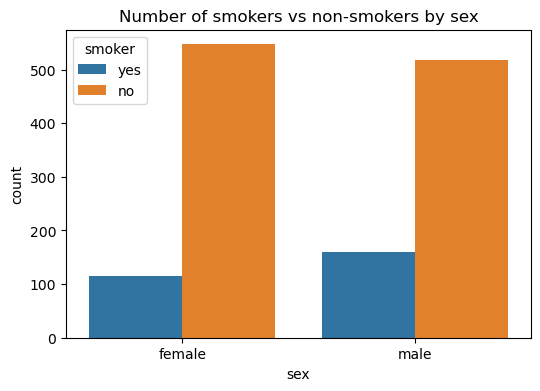

In [23]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Number of smokers vs non-smokers by sex');

The plot above indicates that males are more likely to be smokers than females

## Q3:Do different regions have different charges, on average?

H0 - Different regions have the same charge

H1 - Different regions have different charges

Slignificance Level (Alpha) - 0.05

Test Type - One Way ANOVA

Assumptions:
* No significant outliers
* Equal Variance
* Normality

This code references the Coding Dojo lecture - [ANOVA Tests](https://login.codingdojo.com/m/720/16269/120439)

In [24]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [25]:
# create groups dictionary
groups = {}

# loop through unique regions
for i in df['region'].unique():
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save data in dictionary
    groups[i] = data

In [26]:
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [27]:
groups['southeast']

1        1725.5523
2        4449.4620
5        3756.6216
6        8240.5896
11      27808.7251
           ...    
1322    12981.3457
1323    43896.3763
1327     9377.9047
1330    12629.1656
1335     1629.8335
Name: charges, Length: 364, dtype: float64

In [28]:
# remove significant outliers

for i, data in groups.items():
    # find outliers
    outliers = np.abs(stats.zscore(data)) > 3

    # prints number of outliers per group
    print(f'{i} = {outliers.sum()} outliers')

    # remove outliers
    data = data.loc[~outliers]
    groups[i] = data

southwest = 8 outliers
southeast = 2 outliers
northwest = 7 outliers
northeast = 4 outliers


In [29]:
# normality test on each group
norm_results = {}

for i, data in groups.items():
    stat, p = stats.normaltest(data)

    # save p value, test statisticts and size of group
    norm_results[i] = {'n': len(data),
                       'p': p,
                       'test stat':stat}

In [30]:
# convert dict to df and Transform
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


In [31]:
# check significance of value
norm_results_df['sig'] = norm_results_df['p'] < 0.05
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,318.0,2.940543e-19,85.341045,True
northeast,320.0,3.557877e-17,75.749565,True


Each region does not have a normal distribution, however, the number of samples in each group is greater than 15 so I will proceed with this test.

In [32]:
# testing assumptions of equal variance
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

The p value is < 0.05 which indicates that the assumption of equal variance was not met. I will use the [Kurskal-Wallis](https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/) test going forward.

In [33]:
results = stats.kruskal(*groups.values())
results

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

The p value is greater than 0.05 so I will accept the null hypothesis that there is no significant difference in the charges of each region.

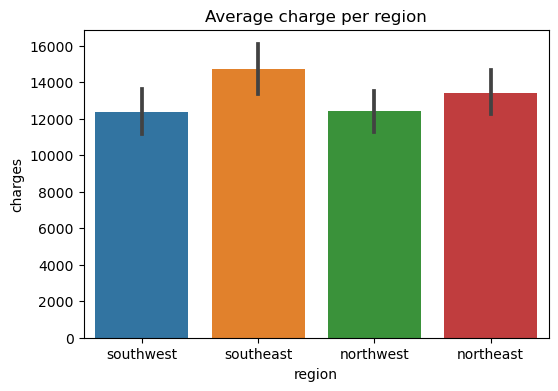

In [34]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=df, x='region', y='charges')
ax.set_title('Average charge per region');

As seen from the bar plot above, each region has a similar average charge